## MNIST Attribution Input Invariance Experiment

Inspiration for the work in this notebook is the study of Kindermans *et al.* (2017) on **input invariance** of various explainable AI (XAI) methods. 

> "If a constant shift does not change the model’s output, the attributions should remain unchanged."


In [1]:
import copy
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from captum.attr import (
    Saliency, GuidedBackprop, InputXGradient,
    IntegratedGradients, GradientShap, NoiseTunnel
)

c:\Users\simon\Desktop\dp\code\learning\quantus\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype']  = 42

In [3]:
torch.manual_seed(0)
np.random.seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Load MNIST data

In [4]:
mean, std = 0.1307, 0.3081
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean,), (std,))
])
test_ds = datasets.MNIST("./data", train=False, download=True, transform=transform)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=True)

### CNN Model

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1,32,3), nn.ReLU(),
            nn.Conv2d(32,64,3), nn.ReLU(),
            nn.MaxPool2d(2), nn.Dropout2d(0.25)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64*12*12,128), nn.ReLU(),
            nn.Dropout(0.5), nn.Linear(128,10)
        )
    def forward(self, x):
        x = self.features(x)
        return self.classifier(x.view(x.size(0), -1))

model = CNN().to(device)
model.load_state_dict(torch.load("ex2_mnist_cnn.pth", map_location=device))
model.eval()

CNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout2d(p=0.25, inplace=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)

### 2nd twin CNN Model (shifted)

In [6]:
# 2nd Twin Model
# - to ensure it produces the same logits as the original model,
#   we need to adjust the bias of the first conv layer:
# x  ... input
# x' ... x + m (shifted input)
# conv1 (CNN1): z  = (w * x + b)
# conv1 (CNN2): z' = (w * x' + b')  
# we want z == z' => (w * x + b) == (w * (x + m) + b') => b' = b - w*m (adjust bias of conv1 CNN2)

m_val = -1.0 / std
m_tensor = torch.full((1,1,28,28), m_val, device=device)
model2 = copy.deepcopy(model).to(device)
with torch.no_grad():
    conv_w = model2.features[0].weight
    conv_b = model2.features[0].bias
    w_sum = conv_w.view(conv_w.size(0), -1).sum(1)
    model2.features[0].bias[:] = conv_b - w_sum * m_val
model2.eval()

# Verify logit invariance on one sample
x0, y0 = next(iter(test_loader))
x0, y0 = x0.to(device), y0.to(device)
with torch.no_grad():
    diff = (model(x0) - model2(x0 + m_tensor)).abs().max().item()
print(f"Max logit difference: {diff:.2e}")

Max logit difference: 1.43e-06


### Attribution Methods

In [7]:
methods = {
    "Saliency": Saliency,
    "GuidedBP": GuidedBackprop,
    "InputXGrad": InputXGradient,
    "IG-zero": IntegratedGradients,
    "IG-black": IntegratedGradients,
    "GS-zero": GradientShap,
    "GS-black": GradientShap
}

In [8]:
methods1, methods2 = {}, {}
for name, Cls in methods.items():
    methods1[name] = Cls(model)
    methods2[name] = Cls(model2)
# Wrap NoiseTunnel for non-baseline methods
for tag in ["Saliency","GuidedBP","InputXGrad"]:
    methods1[f"NT-{tag}"] = NoiseTunnel(methods1[tag])
    methods2[f"NT-{tag}"] = NoiseTunnel(methods2[tag])

In [9]:
# Helper: Baseline selection

def get_baseline(name, x):
    if name.endswith("-zero"): return torch.zeros_like(x)
    return torch.zeros_like(x).sub(mean).div(std)

In [10]:
torch.manual_seed(0)
label = model(x0).argmax().item()

In [11]:
def compute_attrs(methods_dict, x, shift=False):
    attrs = {}
    for name, mtd in methods_dict.items():
        if "IG" in name or "GS" in name:
            b = get_baseline(name, x)
            b2 = b + (m_tensor if name.endswith("-black") and shift else 0)
            if name.startswith("IG"):
                a = mtd.attribute(x + (m_tensor if shift else 0), baselines=b2 if shift else b,
                                  target=label, n_steps=50)
            else:
                bs = torch.randn(50,1,28,28,device=device)*0.1 + (b2 if shift else b)
                a = mtd.attribute(x + (m_tensor if shift else 0), baselines=bs,
                                  target=label, n_samples=50)
        else:
            inp = x + (m_tensor if shift else 0)
            a = mtd.attribute(inp, target=label)
        attrs[name] = a.detach().cpu().squeeze().numpy()
    return attrs

attrs1 = compute_attrs(methods1, x0, shift=False)
attrs2 = compute_attrs(methods2, x0, shift=True)

c:\Users\simon\Desktop\dp\code\learning\quantus\venv\lib\site-packages\captum\attr\_core\saliency.py:129: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(inputs_tuple)
c:\Users\simon\Desktop\dp\code\learning\quantus\venv\lib\site-packages\captum\attr\_core\guided_backprop_deconvnet.py:63: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(inputs_tuple)
c:\Users\simon\Desktop\dp\code\learning\quantus\venv\lib\site-packages\captum\attr\_core\guided_backprop_deconvnet.py:66: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(
c:\Users\simon\Desktop\dp\code\learning\quantus\venv\lib\site-packages\captum\attr\_core\input_x_gradient.py:118: UserWarning: Input Tensor 0 did not already require gradients, required

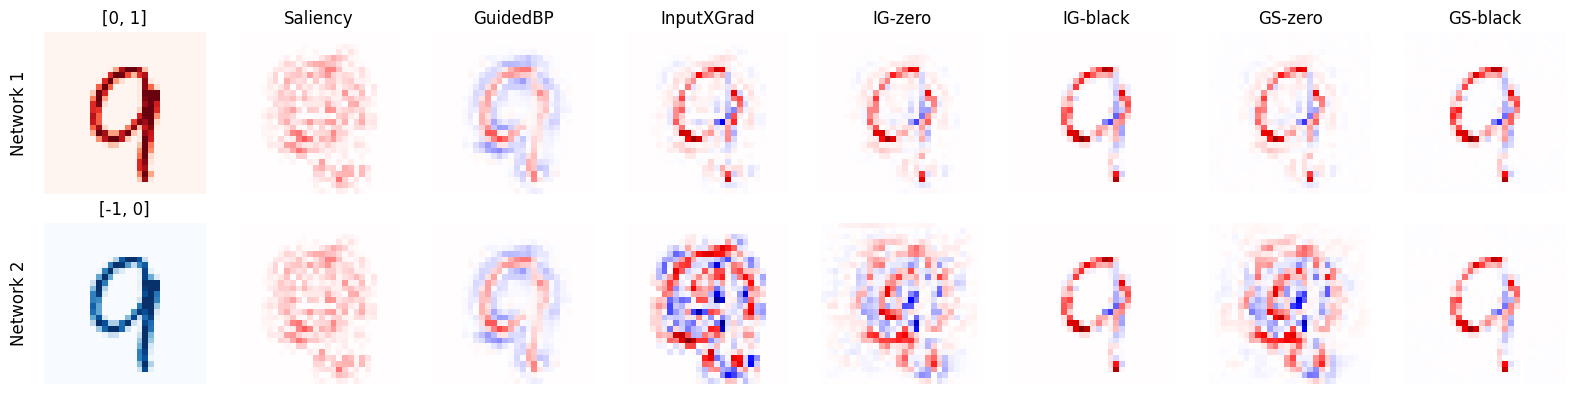

In [ ]:
# 7) Plot a 2×(n+1) grid: inputs + attributions
rows = [
    "Saliency", "GuidedBP", "InputXGrad",
    "IG-zero",  "IG-black",
    "GS-zero",  "GS-black",
]
n = len(rows)

# denormalized raw images
img1 = (x0 * std + mean).cpu().squeeze().numpy()      # ∈ [0,1]
img2 = ((x0 + m_tensor)*std + mean).cpu().squeeze().numpy()  # = x_raw - 1 ∈ [-1,0]

fig, axes = plt.subplots(2, n+1, figsize=(2*(n+1), 4))

# Column 0: the inputs, with DISTINCT colormaps & vmin/vmax
axes[0,0].imshow(img1, cmap="Reds",  vmin=0,  vmax=1)
axes[0,0].set_title("[0, 1]"); axes[0,0].axis("off")

axes[1,0].imshow(img2, cmap="Blues", vmin=-1, vmax=0)
axes[1,0].set_title("[-1, 0]"); axes[1,0].axis("off")

# Columns 1..n: attributions
for j, name in enumerate(rows, start=1):
    axes[0,j].imshow(attrs1[name], cmap="seismic", vmin=-1, vmax=1)
    axes[0,j].axis("off"); axes[0,j].set_title(name)

    axes[1,j].imshow(attrs2[name], cmap="seismic", vmin=-1, vmax=1)
    axes[1,j].axis("off")

# add row labels
axes[0,0].text(-0.1, 0.5, "Network 1",
               transform=axes[0,0].transAxes,
               va="center", ha="right", rotation=90, fontsize=12)
axes[1,0].text(-0.1, 0.5, "Network 2",
               transform=axes[1,0].transAxes,
               va="center", ha="right", rotation=90, fontsize=12)

plt.tight_layout()
plt.savefig("figures/ex3b_input_invariance_heatmap.pdf", bbox_inches="tight")
plt.show()

In [13]:
print("| Method     | Invariant? |")
print("|------------|------------|")
for name in rows:
    d = np.linalg.norm(attrs1[name] - attrs2[name])
    print(f"| {name:<10} | {'✓' if d<1e-4 else '✗':^10} |")

| Method     | Invariant? |
|------------|------------|
| Saliency   |     ✓      |
| GuidedBP   |     ✓      |
| InputXGrad |     ✗      |
| IG-zero    |     ✗      |
| IG-black   |     ✓      |
| GS-zero    |     ✗      |
| GS-black   |     ✗      |


### Checkerboard & Cat Shifts

In [14]:
from PIL import Image, ImageDraw

In [15]:
def make_shift(pattern: str, raw_shift=1.0):
    arr = np.zeros((28,28),dtype=np.float32)
    if pattern=='checker':
        tiles=2; t=28//tiles
        for i in range(tiles):
            for j in range(tiles): arr[i*t:(i+1)*t,j*t:(j+1)*t]=raw_shift*((i+j)%2)
    else: # cat
        img=Image.new('L',(28,28),0); d=ImageDraw.Draw(img)
        d.ellipse((6,6,21,21),fill=int(raw_shift*255))
        d.polygon([(6,9),(10,0),(14,9)],fill=int(raw_shift*255)) 
        d.polygon([(21,9),(17,0),(14,9)],fill=int(raw_shift*255))
        arr=np.array(img,dtype=np.float32)/255*raw_shift
    return torch.tensor(arr/std,device=device).unsqueeze(0).unsqueeze(0)

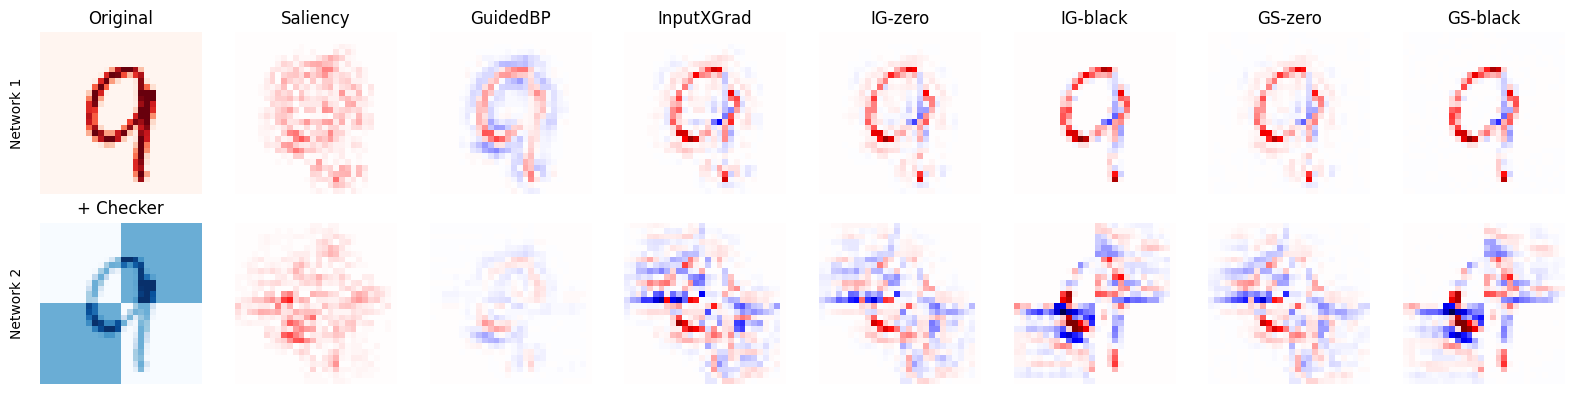

Checker Shift
| Method       | ‖Δ‖₂ |
|--------------|------|
| Saliency     | 1.442 |
| GuidedBP     | 1.123 |
| InputXGrad   | 3.691 |
| IG-zero      | 2.945 |
| IG-black     | 4.168 |
| GS-zero      | 2.823 |
| GS-black     | 4.131 |


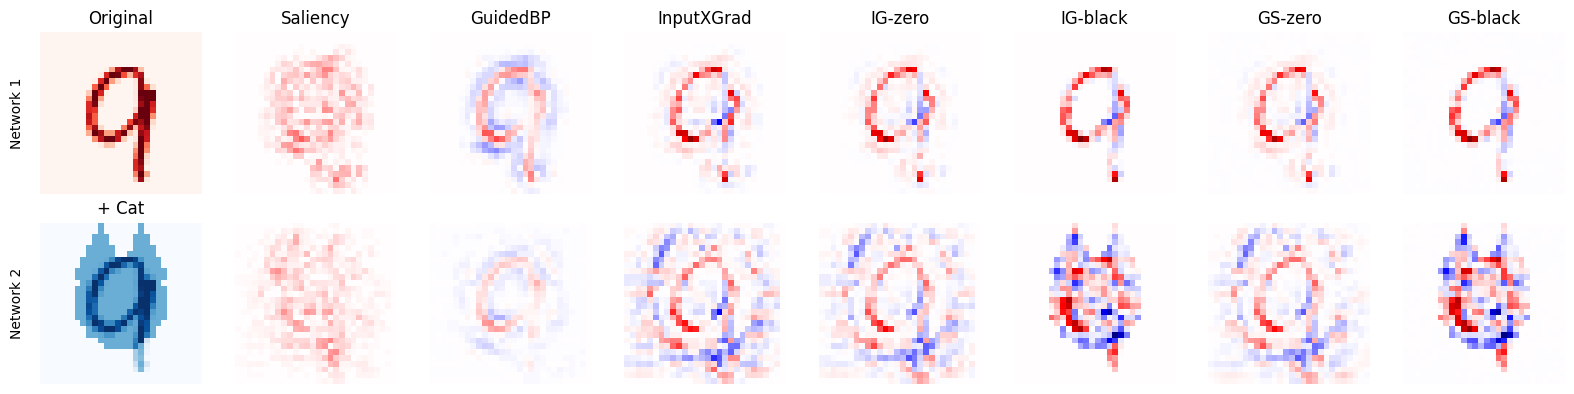

Cat Shift
| Method       | ‖Δ‖₂ |
|--------------|------|
| Saliency     | 1.270 |
| GuidedBP     | 1.029 |
| InputXGrad   | 2.601 |
| IG-zero      | 2.312 |
| IG-black     | 3.195 |
| GS-zero      | 2.174 |
| GS-black     | 3.347 |


In [ ]:
for label_shift in ['checker','cat']:
    m2 = make_shift(label_shift)
    attrs_o = compute_attrs(methods1, x0, shift=False)
    attrs_s = compute_attrs(methods1, x0 + (m2 if label_shift in ['checker','cat'] else 0), shift=True)

    # denormalized images
    img_orig = (x0 * std + mean).cpu().squeeze().numpy()
    img_shift = ((x0 + m2) * std + mean).cpu().squeeze().numpy()

    # plot inputs + attributions
    fig, axes = plt.subplots(2, len(rows)+1, figsize=(2*(len(rows)+1), 4))
    # Input columns
    axes[0,0].imshow(img_orig, cmap='Reds',   vmin=0,  vmax=1); axes[0,0].axis('off'); axes[0,0].set_title('Original')
    axes[1,0].imshow(img_shift, cmap='Blues', vmin=img_shift.min(), vmax=img_shift.max()); axes[1,0].axis('off'); axes[1,0].set_title(f'+ {label_shift.capitalize()}')

    # Attribution columns
    for j, name in enumerate(rows, start=1):
        axes[0,j].imshow(attrs_o[name], cmap='seismic', vmin=-1, vmax=1); axes[0,j].axis('off'); axes[0,j].set_title(name)
        axes[1,j].imshow(attrs_s[name], cmap='seismic', vmin=-1, vmax=1); axes[1,j].axis('off')

    # row labels
    axes[0,0].text(-0.1, 0.5, 'Network 1', transform=axes[0,0].transAxes, va='center', ha='right', rotation=90)
    axes[1,0].text(-0.1, 0.5, 'Network 2',  transform=axes[1,0].transAxes, va='center', ha='right', rotation=90)

    #plt.suptitle(f'Attribution under {label_shift.capitalize()} Shift', y=1.02)
    plt.tight_layout()
    plt.savefig(f"figures/ex3b_{label_shift}_shift.pdf", bbox_inches="tight")
    plt.show()

    # numeric summary
    print(f"{label_shift.capitalize()} Shift")
    print("| Method       | ‖Δ‖₂ |")
    print("|--------------|------|")
    for name in rows:
        diff = np.linalg.norm(attrs_o[name] - attrs_s[name])
        print(f"| {name:<12} | {diff:5.3f} |")